In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0507MedianFilter_3_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.2
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 8s 848ms/step - loss: 0.4641
Average validation loss: 0.5268464684486389
4/4 [==============================] - 8s 867ms/step - loss: 0.4641 - val_loss: 0.5268
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 11s 800ms/step - loss: 0.3554 - val_loss: 0.5268
Average validation loss: 0.5277621746063232
4/4 [==============================] - 11s 819ms/step - loss: 0.3554 - val_loss: 0.5273
Epoch 3/10
4/4 [==============================] - 15s 821ms/step - loss: 0.2884 - val_loss: 0.5273
Average validation loss: 0.5543023347854614
4/4 [==============================] - 15s 839ms/step - loss: 0.2884 - val_loss: 0.5363
Epoch 4/10
4/4 [==============================] - 18s 862ms/step - loss: 0.2386 - val_loss: 0.5363
Average validation loss: 0.5553699135780334
4/4 [==============================] - 18s 877m

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 714ms/step - loss: 0.0265
Average validation loss: 1.2269901162653696e-05
8/8 [==============================] - 6s 727ms/step - loss: 0.0265 - val_loss: 1.2270e-05
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 719ms/step - loss: 0.0262 - val_loss: 1.2270e-05
Average validation loss: 9.947597433279665e-12
8/8 [==============================] - 12s 731ms/step - loss: 0.0262 - val_loss: 6.1350e-06
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 18s 784ms/step - loss: 0.0252 - val_loss: 6.1350e-06
Average validation loss: 6.583416507055517e-06
8/8 [==============================] - 18s 800ms/step - loss: 0.0252 - val_loss: 6.2844e-06
Epoch 4/1

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 739ms/step - loss: 0.0337
Average validation loss: 0.17646624503610533
12/12 [==============================] - 9s 750ms/step - loss: 0.0337 - val_loss: 0.1765
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 734ms/step - loss: 0.0348 - val_loss: 0.1765
Average validation loss: 0.04437385303390329
12/12 [==============================] - 18s 746ms/step - loss: 0.0348 - val_loss: 0.1104
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 27s 739ms/step - loss: 0.0341 - val_loss: 0.1104
Average validation loss: 0.12889486614502252
12/12 [==============================] - 27s 752ms/step - loss: 0.0341 - val_loss: 0.1166
Epoch 4/10
12/12 [======

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 718ms/step - loss: 0.0269
Average validation loss: 0.022040922471205704
16/16 [==============================] - 12s 733ms/step - loss: 0.0269 - val_loss: 0.0220
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 722ms/step - loss: 0.0277 - val_loss: 0.0220
Average validation loss: 0.1729771550269667
16/16 [==============================] - 24s 733ms/step - loss: 0.0277 - val_loss: 0.0975
Epoch 3/10
16/16 [==============================] - 35s 720ms/step - loss: 0.0279 - val_loss: 0.0975
Average validation loss: 0.0778584094827508
16/16 [==============================] - 35s 731ms/step - loss: 0.0279 - val_loss: 0.0910
Epoch 4/10
16/16 [==============================] - 47s 730ms/step - loss: 0.0275 - val_loss: 0.0910
Average validation loss: 0.029326847635275044
16/16 [===================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 725ms/step - loss: 0.0181
Average validation loss: 0.0242015709169209
20/20 [==============================] - 15s 736ms/step - loss: 0.0181 - val_loss: 0.0242
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 735ms/step - loss: 0.0172 - val_loss: 0.0242
Average validation loss: 0.025746394826637698
20/20 [==============================] - 30s 747ms/step - loss: 0.0172 - val_loss: 0.0250
Epoch 3/10
20/20 [==============================] - 44s 717ms/step - loss: 0.0166 - val_loss: 0.0250
Average validation loss: 0.03820162821663189
20/20 [==============================] - 44s 730ms/step - loss: 0.0166 - val_loss: 0.0294
Epoch 4/10
20/20 [==============================] - 59s 720ms/step - loss: 0.0166 - val_loss: 0.0294
Average validation loss: 0.020550833208562835
20/20 [==================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 726ms/step - loss: 0.0173
Average validation loss: 0.021988654509186745
24/24 [==============================] - 18s 737ms/step - loss: 0.0173 - val_loss: 0.0220
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 724ms/step - loss: 0.0158 - val_loss: 0.0220
Average validation loss: 0.01785290411983927
24/24 [==============================] - 35s 736ms/step - loss: 0.0158 - val_loss: 0.0199
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 53s 738ms/step - loss: 0.0151 - val_loss: 0.0199
Average validation loss: 0.028284625771145027
24/24 [==============================] - 53s 750ms/step - loss: 0.0151 - val_loss: 0.0227
Epoch 4/10
24/24 [==

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 732ms/step - loss: 0.0226
Average validation loss: 0.04795708414167166
40/40 [==============================] - 30s 744ms/step - loss: 0.0226 - val_loss: 0.0480
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 59s 736ms/step - loss: 0.0208 - val_loss: 0.0480
Average validation loss: 0.034427545964717865
40/40 [==============================] - 60s 749ms/step - loss: 0.0208 - val_loss: 0.0412
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 89s 722ms/step - loss: 0.0199 - val_loss: 0.0412
Average validation loss: 0.028742189053446054
40/40 [==============================] - 89s 736ms/step - loss: 0.0199 - val_loss: 0.0370
Saved model weights 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 721ms/step - loss: 0.0163
Average validation loss: 0.013821383475705365
48/48 [==============================] - 35s 733ms/step - loss: 0.0163 - val_loss: 0.0138
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 726ms/step - loss: 0.0145 - val_loss: 0.0138
Average validation loss: 0.01310795552192919
48/48 [==============================] - 71s 738ms/step - loss: 0.0145 - val_loss: 0.0135
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 106s 737ms/step - loss: 0.0133 - val_loss: 0.0135
Average validation loss: 0.011086800354884666
48/48 [==============================] - 107s 750ms/step - loss: 0.0133 - val_loss: 0.0127
Saved model weight

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 723ms/step - loss: 0.0152
Average validation loss: 0.017732140320785968
56/56 [==============================] - 41s 735ms/step - loss: 0.0152 - val_loss: 0.0177
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 81s 719ms/step - loss: 0.0138 - val_loss: 0.0177
Average validation loss: 0.01769911456125785
56/56 [==============================] - 82s 731ms/step - loss: 0.0138 - val_loss: 0.0177
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 122s 718ms/step - loss: 0.0120 - val_loss: 0.0177
Average validation loss: 0.016991610341777225
56/56 [==============================] - 123s 730ms/step - loss: 0.0120 - val_loss: 0.0175
Saved model weight

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 47s 733ms/step - loss: 0.0117
Average validation loss: 0.013284586346947881
64/64 [==============================] - 48s 746ms/step - loss: 0.0117 - val_loss: 0.0133
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 94s 722ms/step - loss: 0.0109 - val_loss: 0.0133
Average validation loss: 0.033729914925061166
64/64 [==============================] - 95s 734ms/step - loss: 0.0109 - val_loss: 0.0235
Epoch 3/10
64/64 [==============================] - 142s 734ms/step - loss: 0.0100 - val_loss: 0.0235
Average validation loss: 0.010527261067181826
64/64 [==============================] - 142s 746ms/step - loss: 0.0100 - val_loss: 0.0192
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_80.pth'.
Epoch 4/10
64/64 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 724ms/step - loss: 0.0119
Average validation loss: 0.008902118062703974
72/72 [==============================] - 53s 737ms/step - loss: 0.0119 - val_loss: 0.0089
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 105s 727ms/step - loss: 0.0095 - val_loss: 0.0089
Average validation loss: 0.007941429192821184
72/72 [==============================] - 106s 739ms/step - loss: 0.0095 - val_loss: 0.0084
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 159s 728ms/step - loss: 0.0084 - val_loss: 0.0084
Average validation loss: 0.024869189856366977
72/72 [==============================] - 160s 741ms/step - loss: 0.0084 - val_loss: 0.0139
Epoch 4/10
72/7

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 57s 719ms/step - loss: 0.0103
Average validation loss: 0.018678754521533846
80/80 [==============================] - 58s 731ms/step - loss: 0.0103 - val_loss: 0.0187
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 719ms/step - loss: 0.0085 - val_loss: 0.0187
Average validation loss: 0.007955450378358365
80/80 [==============================] - 117s 731ms/step - loss: 0.0085 - val_loss: 0.0133
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 175s 721ms/step - loss: 0.0079 - val_loss: 0.0133
Average validation loss: 0.0075126485549844805
80/80 [==============================] - 176s 733ms/step - loss: 0.0079 - val_loss: 0.0114
Saved model 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 721ms/step - loss: 0.0162
Average validation loss: 0.05946095930009913
96/96 [==============================] - 70s 733ms/step - loss: 0.0162 - val_loss: 0.0595
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 140s 723ms/step - loss: 0.0131 - val_loss: 0.0595
Average validation loss: 0.03740963608773503
96/96 [==============================] - 141s 735ms/step - loss: 0.0131 - val_loss: 0.0484
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 210s 722ms/step - loss: 0.0117 - val_loss: 0.0484
Average validation loss: 0.021512234640141514
96/96 [==============================] - 211s 734ms/step - loss: 0.0117 - val_loss: 0.0395
Saved model wei

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 718ms/step - loss: 0.0117
Average validation loss: 0.016029312601312996
120/120 [==============================] - 88s 730ms/step - loss: 0.0117 - val_loss: 0.0160
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 719ms/step - loss: 0.0107 - val_loss: 0.0160
Average validation loss: 0.010983858544689914
120/120 [==============================] - 175s 732ms/step - loss: 0.0107 - val_loss: 0.0135
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 263s 725ms/step - loss: 0.0100 - val_loss: 0.0135
Average validation loss: 0.0641626238822937
120/120 [==============================] - 264s 737ms/step - loss: 0.0100 - val_loss: 0.0304
Epo

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 104s 723ms/step - loss: 0.0108
Average validation loss: 0.04395022843446997
144/144 [==============================] - 106s 735ms/step - loss: 0.0108 - val_loss: 0.0440
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 210s 720ms/step - loss: 0.0100 - val_loss: 0.0440
Average validation loss: 0.02317481134817487
144/144 [==============================] - 211s 732ms/step - loss: 0.0100 - val_loss: 0.0336
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 315s 721ms/step - loss: 0.0096 - val_loss: 0.0336
Average validation loss: 0.01712539197695959
144/144 [==============================] - 317s 733ms/step - loss: 0.0096 - val_loss: 0.0281
Sa

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 721ms/step - loss: 0.0163
Average validation loss: 0.14523535972046772
160/160 [==============================] - 117s 734ms/step - loss: 0.0163 - val_loss: 0.1452
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 233s 724ms/step - loss: 0.0139 - val_loss: 0.1452
Average validation loss: 0.017126022102456773
160/160 [==============================] - 235s 736ms/step - loss: 0.0139 - val_loss: 0.0812
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 351s 725ms/step - loss: 0.0132 - val_loss: 0.0812
Average validation loss: 0.019583091820823028
160/160 [==============================] - 353s 737ms/step - loss: 0.0132 - val_loss: 0.0606


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 720ms/step - loss: 0.0137
Average validation loss: 0.015315309157595039
200/200 [==============================] - 147s 733ms/step - loss: 0.0137 - val_loss: 0.0153
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 291s 720ms/step - loss: 0.0132 - val_loss: 0.0153
Average validation loss: 0.019205231172412816
200/200 [==============================] - 293s 732ms/step - loss: 0.0132 - val_loss: 0.0173
Epoch 3/10
200/200 [==============================] - 437s 722ms/step - loss: 0.0126 - val_loss: 0.0173
Average validation loss: 0.10228648332122248
200/200 [==============================] - 440s 734ms/step - loss: 0.0126 - val_loss: 0.0456
Epoch 4/10
200/200 [==============================] - 584s 722ms/step - loss: 0.0123 - val_loss: 0.0456
Average validation loss: 0.05139657132327557
20

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:11 - loss: 0.0046

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 174s 727ms/step - loss: 0.0104
Average validation loss: 0.019191129257887952
240/240 [==============================] - 177s 739ms/step - loss: 0.0104 - val_loss: 0.0192
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 351s 722ms/step - loss: 0.0106 - val_loss: 0.0192
Average validation loss: 0.01895132677212435
240/240 [==============================] - 354s 734ms/step - loss: 0.0106 - val_loss: 0.0191
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_20\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 528s 725ms/step - loss: 0.0100 - val_loss: 0.0191
Average validation loss: 0.01739553940734974
240/240 [==============================] - 531s 737ms/step - loss: 0.0100 - val_loss: 0.0185
S

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.08677143715516357, 0.06982168373641966, 0.10343969298818344, 0.04809125131024311, 0.02606705732633799, 0.0237322198025267, 0.02051190935890626, 0.013051178694164042, 0.01917588313022541, 0.009761639359915822, 0.009356390105995713, 0.008345868039251544, 0.014745892515985777, 0.023407486202378022, 0.014269124225005219, 0.022696695135867775, 0.019867019647683185, 0.02444275285488677]
std_val_losses =  [0.16283941526954523, 0.05401785924695673, 0.09151785047072052, 0.03292135396976224, 0.012665008593435544, 0.019182351749314198, 0.013097880929533422, 0.0076859608130693076, 0.020993703186033094, 0.0049790410312378994, 0.006948496357629423, 0.006800422749574947, 0.0122956851488319, 0.07506507649414483, 0.017291270554131693, 0.04352780637446905, 0.025464011684080388, 0.0461121549535226]


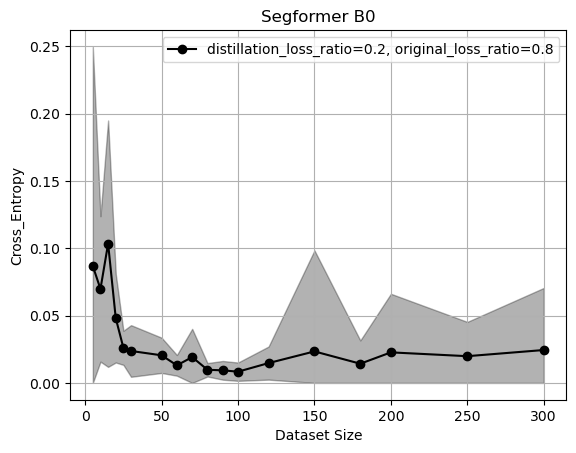

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()